## Zadanie 1

$$ c(S_{0},T,K,\sigma,r) :=S_{0}\Phi(d_{+}(S_{0},T,K,\sigma,r))− Ke^{−rT}\Phi(d_{−}(S_{0},T,K,\sigma,r)),$$

gdzie $\Phi$ jest dystrybuantą rozkładu $N(0,1)$ oraz 

$$ d_{±}(S_{0},T,K,\sigma,r) :=\frac{log \frac{S_{0}}{K} + (r± \frac{\sigma^{2}}{2})T}{\sigma \sqrt{T}}.$$

In [3]:
import scipy.stats
from math import  e, sqrt, factorial, floor, log

def d1(S0, T, K, sigma, r):
    return (log(S0/K) + (r + sigma**2 /2)*T)/(sigma*sqrt(T))

def c(S0, T, K, sigma, r):
    return S0* scipy.stats.norm.cdf(d1(S0, T, K, sigma, r)) - K*e**(-r*T)*scipy.stats.norm.cdf(d1(S0, T, K, sigma, r)- sigma*sqrt(T))

c(100, 1, 100, 0.1, 0.1)

10.308150925634422

In [141]:
def CRR_contingence_prep(T, n, sigma, r):
    r_n = r * T/n
    a_n = sigma * sqrt(T/n)
    u_n = e** (a_n) * (1+r_n)
    d_n = e** (-a_n) * (1+r_n)
    return d_n, u_n, r_n, n

prices = []
step=1
left, right = 800, 2000
for n in range(left, right, step):
    example_market = CRRMarket([100], *CRR_contingence_prep(T=1, n=n, sigma=0.1, r=0.1))
#     prices.append(calculate_option_value_theory(example_market.S[0].get_call_option_value, example_market,example_market.T, 80))
    prices.append(example_market.S[0].calculate_call_option_value(example_market,example_market.T, 100))

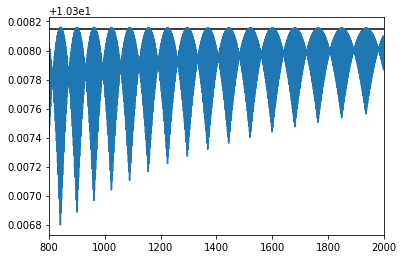

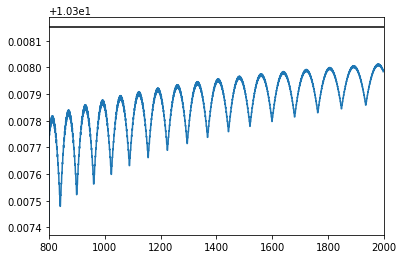

In [144]:
import matplotlib.pyplot as plt

plt.xlim(left, right)
plt.plot([prices[0]]*left +prices)
plt.hlines(c(100, 1, 100, 0.1, 0.1), xmin=0, xmax=right)
plt.show()

plt.xlim(left, right)
plt.plot([prices[0]]*left + [(prices[i-1] +prices[i])/2 for i in range(1, len(prices))])
plt.hlines(c(100, 1, 100, 0.1, 0.1), xmin=0, xmax=right)
plt.show()

Implementacja Modelu CRR:

In [64]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()


In [6]:
class BankAccount:
    def __init__(self, r):
        self.r = r

    def get_bank_account_value(self, t):
        return (1 + self.r) ** t


class MarketInstrument:
    def __init__(self, S_0):
        self.S_0 = S_0

    def calculate_call_option_value(self, market, T, K):
        return self._calculate_option_value(self.get_call_option_value, market, T, K)
        
    def calculate_put_option_value(self, market, T, K):
        return self._calculate_option_value(self.get_put_option_value, market, T, K)

    def _calculate_option_value(self, option_func_type, market, t, K):
        prices = [option_func_type(t, t-j, market.d, market.u, K) for j in range(0, t+1)]
        return self._get_value(t, prices, market.d, market.u, market.r, market.p)
    
    def _get_value(self, t, prices, d, u,r, p):
        if t == 0:
            return prices[0]
        else:
            for i in range(0, t):
                prices[i] =1/(1+r)*(p*prices[i] + (1-p)*prices[i+1])
            #print(prices[:t])
            return self._get_value(t-1, prices, d, u,r,  p)

    
    def get_call_option_value(self, t, j, d, u, K):
        return max(self.S_0 * u ** j * d ** (t - j) - K, 0)
    
    def get_put_option_value(self, t, j, d, u, K):
        return max(K - self.S_0 * u ** j * d ** (t - j), 0)

hide_toggle()

In [7]:
class CRRMarket:
    def __init__(self, S_0_values, d, u, r, T):
        self.B = BankAccount(r)
        self.p = (1 + r - d) / (u - d)
        self.S = [MarketInstrument(S_0_values[i]) for i in range(0, len(S_0_values))]
        self.d = d
        self.u = u
        self.r = r
        self.T = T
    
    def calculate_call_options_values(self, T, K):
        return [s.calculate_call_option_value(self, T, K[i]) for i, s in enumerate(self.S)]
    
    def calculate_put_options_values(self, T, K):
        return [s.calculate_put_option_value(self, T, K[i]) for i, s in enumerate(self.S)]
    
hide_toggle()

In [129]:
import scipy.special
def calculate_option_value_theory(option_func_type, market, t, K):
        scaling_value = 1 / market.B.get_bank_account_value(t)
        sum = 0
        for j in range(0, t+1):
            sum += scipy.special.comb(t, j, exact=True) * market.p ** j * (1 - market.p) ** (t - j) * option_func_type(t, j, market.d, market.u, K)
        return sum * scaling_value
hide_toggle()

## Zadanie 2

In [8]:
from tqdm import tqdm

In [88]:
n = 100000
number_of_vectors = 10
vectors = [generate_S_T_vectors(n=n, S_0=100, T=1, sigma=0.1, r = 0.1) for i in range(0, number_of_vectors)]
S_T = np.array([vectors[x][y][0] for x in range(0, number_of_vectors) for y in range(0,n)]).reshape(number_of_vectors, n)
S_T_prim = np.array([vectors[x][y][1] for x in range(0, number_of_vectors) for y in range(0,n)]).reshape(number_of_vectors, n)

In [78]:
import numpy as np

def MC_approximation(n, S_T, S_0, T, sigma, r, K):
    means = []
    for i in tqdm(range(0, n)):
        value = e ** (-r*T) * max(S_T[i]-K, 0)
        if not means:
            means.append(value)
        else:
            means.append(np.average([means[i-1], value], weights = [i, 1]))
    return means

def generate_S_T_vectors(n, S_0, T, sigma, r):
    return [generate_single_S_T(S_0, T, sigma, r) for i in range(0, n)]

def generate_single_S_T(S_0, T, sigma, r):
    rand_normal = np.random.normal()
    return S_0*e**(sigma*sqrt(T)*rand_normal + (r - sigma**2/2)*T), S_0*e**(sigma*sqrt(T)*(-rand_normal) + (r - sigma**2/2)*T)

# a_E = MC_approximation(n=10000,S_T=S_T[0],  S_0=100, T=1, sigma=0.1, r = 0.1, K=100)

100%|██████████| 100000/100000 [00:02<00:00, 49443.85it/s]


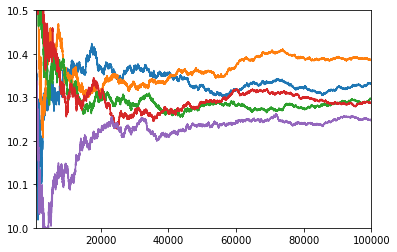

In [333]:
plt.xlim(10**3, 10**5)
plt.ylim(10, 10.5)
for i in range(0, 5):
    plt.plot(MC_approximation(n=100000, S_0=100, T=1, sigma=0.1, r = 0.1, K=100))
plt.show()

In [89]:
scipy.stats.describe([MC_approximation(n=100000, S_T=S_T[i], S_0=100, T=1, sigma=0.1, r = 0.1, K=100)[-1] for i in range(0, 10)])

100%|██████████| 100000/100000 [00:02<00:00, 43501.76it/s]


DescribeResult(nobs=10, minmax=(10.288913878614908, 10.34836050140434), mean=10.318489126763783, variance=0.000589368414660989, skewness=-0.15174944679735264, kurtosis=-1.6066915483381787)

(a) metoda zmiennych kontrolnych

In [41]:
def control_variables(n, S_T, S_0, T, sigma, r, K):
    means = []
#     k_means = [] # assume we know u_k
    for i in tqdm(range(0, n)):
        k = e ** (-r*T) * S_T[i]
        value = e ** (-r*T) * max(S_T[i]-K, 0)
        if not means:
#             k_means.append(k)
            means.append(value-k)
        else:
#             k_means.append(np.average([k_means[i-1], k], weights = [i, 1]))
            means.append(np.average([means[i-1], value-k], weights = [i, 1]))
#     print(k_means[-1])
#     return k_means[-1] + means
    return [x + S_0 for x in means]

In [90]:
scipy.stats.describe([control_variables(n=100000, S_T=S_T[i], S_0=100, T=1, sigma=0.1, r = 0.1, K=100)[-1] for i in range(0, 10)])

100%|██████████| 100000/100000 [00:02<00:00, 42640.09it/s]


DescribeResult(nobs=10, minmax=(10.302748049187088, 10.318109485016208), mean=10.309789653014823, variance=2.7268813965305938e-05, skewness=0.2688669597550306, kurtosis=-0.9166458690272115)

(b) metoda zmiennych kontrolnych w wersji turbo

In [35]:
arguments={
    'n':100000, 
    'S_0':100, 
    'T':1, 
    'sigma':0.1, 
    'r':0.1, 
    'K':100
}

In [67]:
def control_variables_turbo(n, S_T, S_0, T, sigma, r, K):
    means = []
    values= []
    X_mean = []
    Y_mean = []
    sum_covariances = 0
    sum_variances= 0
    b= 0
    for i in tqdm(range(0, n)):
        value = e ** (-r*T) * max(S_T[i]-K, 0)
        if not means:
            values.append(value)
            means.append(value)
            X_mean.append(value)
            Y_mean.append(S_T[i])
        else:
            values.append(value)
            X_mean.append(np.average([X_mean[i-1], value], weights = [i, 1]))
            Y_mean.append(np.average([Y_mean[i-1], S_T[i]], weights = [i, 1]))
            sum_covariances += (value - X_mean[i])*(S_T[i]- Y_mean[i]) 
            sum_variances += (S_T[i]- Y_mean[i]) **2
            b_hat = sum_covariances/sum_variances
            means.append(np.average([means[i-1], value-b_hat*S_T[i]], weights = [i, 1]))
            b=b_hat
#     print(b, Y_mean[-1])
    return [x + b*Y_mean[-1] for x in means]

In [68]:
scipy.stats.describe([control_variables_turbo(n=100000, S_T=S_T[i], S_0=100, T=1, sigma=0.1, r = 0.1, K=100)[-1] for i in range(0, 10)])

  3%|▎         | 3154/100000 [00:00<00:06, 15785.08it/s]

0.7816599317993516 110.4995400958922


  3%|▎         | 3143/100000 [00:00<00:06, 15802.39it/s]

0.7815958489977733 110.51772536014354


  3%|▎         | 3138/100000 [00:00<00:06, 15730.08it/s]

0.782902363026796 110.54702368411783


  3%|▎         | 3190/100000 [00:00<00:06, 15964.41it/s]

0.7819984515065915 110.55101343002076


  3%|▎         | 3130/100000 [00:00<00:06, 15778.51it/s]

0.7808905419604273 110.47409439110577


  3%|▎         | 2990/100000 [00:00<00:06, 15031.17it/s]

0.7818102546340973 110.50868686238682


  3%|▎         | 3144/100000 [00:00<00:06, 15723.90it/s]

0.7829776230390901 110.53757583392846


  3%|▎         | 3154/100000 [00:00<00:06, 15809.57it/s]

0.7831564966100474 110.52222983243301


  3%|▎         | 3240/100000 [00:00<00:05, 16245.03it/s]

0.7808243273290426 110.49158857826886


100%|██████████| 100000/100000 [00:06<00:00, 16061.94it/s]

0.7825115505423244 110.51996083405955


DescribeResult(nobs=10, minmax=(10.140450327529507, 10.548662858316533), mean=10.334513507947701, variance=0.018284632401298448, skewness=0.25087072583546216, kurtosis=-1.1804783475723652)

(c) metoda zmiennych antytetycznych

In [91]:
def antitetic_variables(n, S_T, S_T_prim, S_0, T, sigma, r, K):
    means = []
    for i in tqdm(range(0, n)):
        value = e ** (-r*T) * max(S_T[i]-K, 0)
        value_prim = e ** (-r*T) * max(S_T_prim[i]-K, 0)
        if not means:
            means.append((value + value_prim)/2)
        else:
            means.append(np.average([means[i-1], (value + value_prim)/2], weights = [i, 1]))
    return means

In [92]:
scipy.stats.describe([antitetic_variables(n=100000, S_T=S_T[i], S_T_prim = S_T_prim[i] , S_0=100, T=1, sigma=0.1, r = 0.1, K=100)[-1] for i in range(0, 10)])

100%|██████████| 100000/100000 [00:02<00:00, 42628.26it/s]


DescribeResult(nobs=10, minmax=(10.303652429987874, 10.318577895880633), mean=10.310221073033663, variance=2.6057386182288376e-05, skewness=0.30620324143217864, kurtosis=-1.1824113705206434)

Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł. Stanisław Pawlak